In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
import re
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

dataset = load_dataset('imdb')

def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

vocab = Counter()
for example in dataset['train']:
    tokens = tokenize(example['text'])
    vocab.update(tokens)

vocab_size = 10000
common_words = vocab.most_common(vocab_size - 2)
word2idx = {word: idx + 2 for idx, (word, _) in enumerate(common_words)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

max_len = 500

def text_to_sequence(text, word2idx, max_len):
    tokens = tokenize(text)
    sequence = [word2idx.get(token, 1) for token in tokens]
    if len(sequence) > max_len:
        sequence = sequence[:max_len]
    else:
        sequence += [0] * (max_len - len(sequence))
    return sequence

def process_dataset(data, word2idx, max_len):
    sequences = []
    labels = []
    for example in data:
        seq = text_to_sequence(example['text'], word2idx, max_len)
        sequences.append(seq)
        labels.append(example['label'])
    return torch.tensor(sequences), torch.tensor(labels)

X_train, y_train = process_dataset(dataset['train'], word2idx, max_len)
X_test, y_test = process_dataset(dataset['test'], word2idx, max_len)

# DataLoader
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
class TransformerModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=2, num_layers=3,
                 hidden_dim=256, num_classes=4, max_len=500, dropout=0.1):
        super(TransformerModelWithAttention, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = num_heads, dim_feedforward = hidden_dim, dropout = dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers = num_layers)

        self.fc_out = nn.Linear(embed_dim, num_classes)
        self.attention_weights = []

    def forward(self, X):
            B, S = X.size()
            emb = self.embedding(X) + self.positional_encoding[:, :S, :]
            out = emb
            self.attention_weights = []
            for layer in self.transformer_encoder.layers:
                attn_out, attn_w = layer.self_attn(out, out, out, need_weights=True)
                ff = layer.linear2(layer.dropout(layer.activation(layer.linear1(attn_out))))
                out = layer.norm2(ff + layer.dropout(attn_out))
                out = layer.norm1(out + layer.dropout(out)) if False else out
                self.attention_weights.append(attn_w.detach().cpu())
            pooled = out.mean(dim=1)
            logits = self.fc_out(pooled)
            return logits

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModelWithAttention(max_len=max_len, num_classes=2, vocab_size=vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

def train_with_logging(model, train_loader, test_loader, optimizer, criterion, epochs = 5):
  losses = []
  # accuracies = []
  for epoch in range(epochs):
      model.train()
      total_loss=0
      for X, y in train_loader:
          X, y = X.to(device), y.to(device)
          optimizer.zero_grad()
          logits = model(X)
          loss = criterion(logits, y)
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
      avg_loss = total_loss / len(train_loader)
      # val_acc = evaluate(model, test_loader)
      losses.append(avg_loss)
      # accuracies.append(val_acc)
      print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
  return losses

losses = train_with_logging(model, train_loader, test_loader, optimizer, criterion)

Epoch 1/5, Loss: 0.5588
Epoch 2/5, Loss: 0.3538
Epoch 3/5, Loss: 0.3873
Epoch 4/5, Loss: 0.2704
Epoch 5/5, Loss: 0.2437


In [ ]:
from tqdm import tqdm

def evaluate(model, val_loader):
    model.eval()
    correct_preds, total_preds=0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = logits.argmax(dim=1)
            correct_preds += (preds == y).sum().item()
            total_preds += y.size(0)
    return correct_preds / total_preds

def mmc_evaluate(model, val_loader, T=50):
    model.train()
    correct, total = 0, 0
    all_batch_preds = []
    with torch.no_grad():
        for X, y in tqdm(val_loader):
            X, y = X.to(device), y.to(device)
            all_predictions = []
            for i in range(T):
                logits = model(X)
                preds = logits.argmax(dim=1)
                all_predictions.append(preds.cpu().numpy())
                if len(all_batch_preds) == T:
                  all_batch_preds[i] += list(preds)
                else:
                  all_batch_preds.append(list(preds))

            all_predictions = np.array(all_predictions)
            final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis = 0, arr = all_predictions)
            correct += (final_predictions == y.cpu().numpy()).sum()
            total += len(final_predictions)
    return correct / total, all_batch_preds

accuracy = evaluate(model, test_loader)
mmc_accuracy, all_predictions = mmc_evaluate(model, test_loader)

# Вывод результатов
print(f"Точность с MC Dropout: {mmc_accuracy:.2f}%")
print(f"Точность без MC Dropout: {accuracy:.2f}%")

100%|██████████| 391/391 [1:02:05<00:00,  9.53s/it]

Точность с MC Dropout: 0.86%
Точность без MC Dropout: 0.86%


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

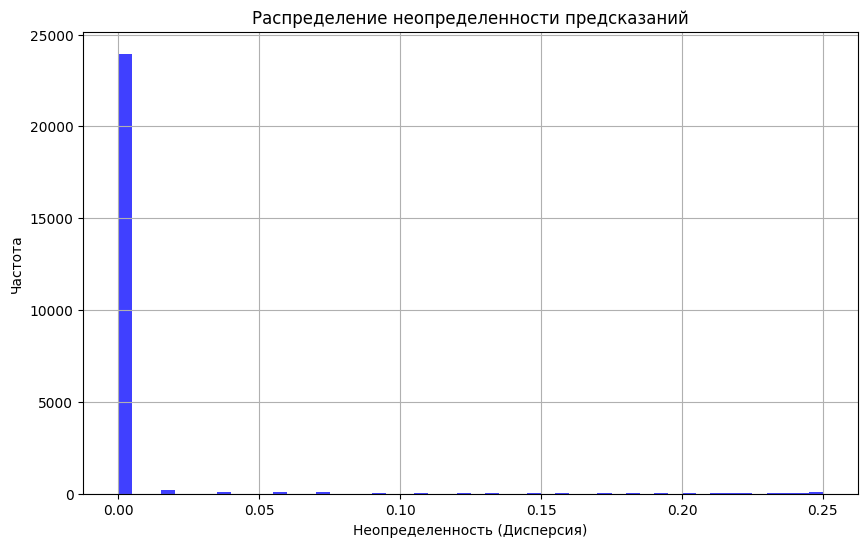

In [ ]:
# Визуализация неопределенности
uncertainties = np.var(np.array(torch.Tensor(all_predictions).cpu()), axis=0) # Неопределенность - это дисперсия

# Визуализация распределения неопределенности
plt.figure(figsize = (10, 6))
plt.hist(uncertainties, bins = 50, alpha = 0.75, color = "blue")
plt.title("Распределение неопределенности предсказаний")
plt.xlabel("Неопределенность (Дисперсия)")
plt.ylabel("Частота")
plt.grid(True)
plt.show()